In [1]:
import mdtraj as md
traj = md.load('butane_sim.dcd', top='butane.pdb')

In [2]:
import os
import sys
from simtk import openmm as mm

import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *

import numpy as np

#import pytraj as pt
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from statistics import mean, stdev
#from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

import mdtraj as md

In [3]:
traj

<mdtraj.Trajectory with 200000 frames, 14 atoms, 1 residues, without unitcells at 0x7fded8648d90>

In [4]:
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=199999)

In [5]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [6]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x7fdeca302690>

In [7]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


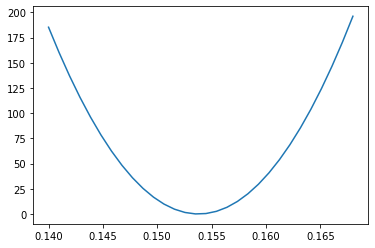

In [8]:
bondlengths=np.linspace(0.140,0.168,30)

#array bond lengths
def harmonic_bond_E(k,b,b0):
    return(k/2*(b-b0)**2)

Bond_E=harmonic_bond_E(1945727.27,bondlengths,0.15380)

plt.plot(bondlengths,Bond_E)

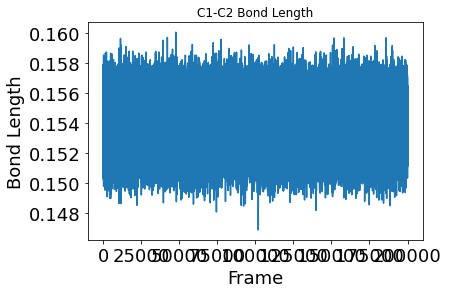

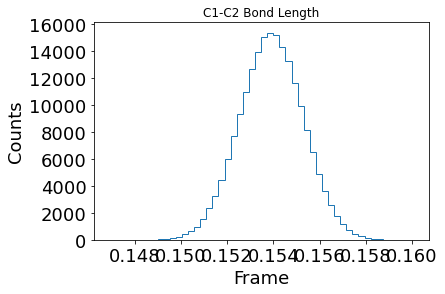

In [9]:
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])

plt.plot(C1C2bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')

plt.show()
plt.clf()

plt.hist(C1C2bondlength,bins=50,histtype='step')
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Counts', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

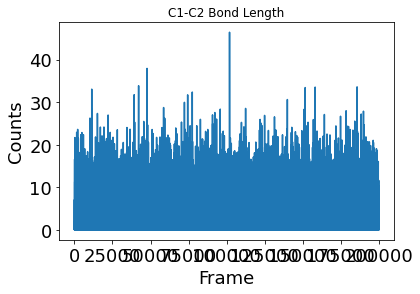

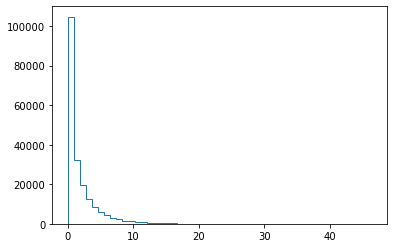

In [10]:
C1C2bond=C1C2bondlength[:,0]

C1C2_BondE=harmonic_bond_E(1945727.27,C1C2bond,0.15380)
plt.plot(C1C2_BondE)

plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Counts', size=18)
plt.title('C1-C2 Bond Length')
plt.show()
plt.clf()

plt.hist(C1C2_BondE,histtype='step',bins=50)
plt.show()

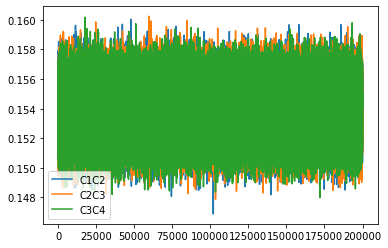

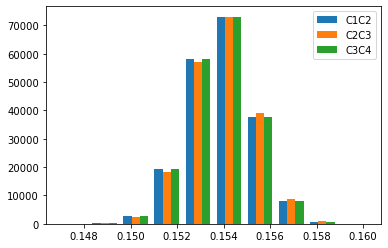

In [11]:
bond_indices = [[0, 4],[4, 7],[7, 10]]
CC_bondlengths = md.compute_distances(traj, bond_indices)

C1C2_bond=CC_bondlengths[:,0]
C2C3_bond=CC_bondlengths[:,1]
C3C4_bond=CC_bondlengths[:,2]

plt.plot(CC_bondlengths,label=['C1C2','C2C3','C3C4'])
plt.legend()
plt.show()
plt.clf()

plt.hist(CC_bondlengths,label=['C1C2','C2C3','C3C4'])
plt.legend()

In [12]:
np.shape(CC_bondlengths[:,0])

(200000,)

In [13]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2_bond)
C2C3var,C2C3std=variance(C2C3_bond)
C3C4var,C3C4std=variance(C3C4_bond)
print("C1-C2 var:",C1C2var,"C2-C3 var:",C2C3var,"C3-C4 var:",C3C4var)
print("C1-C2 std:",C1C2std,"C2-C3 std:",C2C3std,"C3-C4 std:",C3C4std)

C1-C2 var: 1.8723163e-06 C2-C3 var: 1.8877237e-06 C3-C4 var: 1.8810842e-06
C1-C2 std: 0.001368326079975917 C2-C3 std: 0.0013739445657756652 C3-C4 std: 0.0013715262464913682


R2: -0.09870278038244278
Line Parameters: [0.50013215 0.07697495]


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


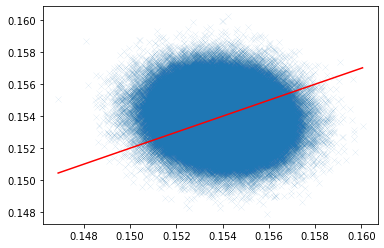

Line Parameters: [0.49996827 0.07694973]


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


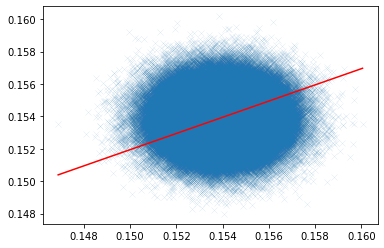

R2: 0.008319309854469947


<Figure size 432x288 with 0 Axes>

In [14]:
plt.scatter(C1C2_bond,C2C3_bond,marker='x',linewidth=.05)

r2=np.corrcoef(C1C2_bond,C2C3_bond)[0,1]
print("R2:",r2)

line_fit=np.polyfit(C1C2_bond,C2C3_bond,1)
x = np.linspace(min(C1C2_bond), max(C1C2_bond),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

plt.scatter(C1C2_bond,C3C4_bond,marker='x',linewidth=.05)
x = np.linspace(min(C1C2_bond), max(C1C2_bond),20)
line_fit=np.polyfit(C1C2_bond,C3C4_bond,1)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r2=np.corrcoef(C1C2_bond,C3C4_bond)[0,1]

print("R2:",r2)

a: 0.187981273151214 x0: 0.1539071225695303 fit_sigma: -0.0013789898541600948


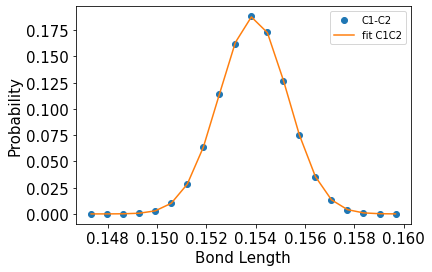

In [15]:

from scipy.optimize import curve_fit

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bond, bins=20, range=[0.147,0.160])
centers = edges[:-1] + np.diff(edges)/2
density=counts/np.sum(counts)

###Now we define a gaussian function that we'll fit to our probability densities

def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers


def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 




C1C2_density,centers=histogram_bincenters(C1C2bond,0.147,0.160,20)

C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density)

plt.plot(centers, C1C2_density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

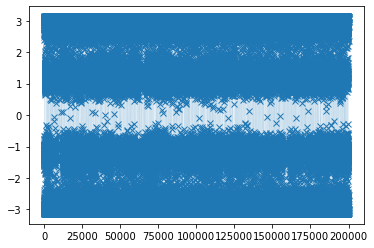

In [16]:
Angle1=[0,4,7]
Angle2=[4,7,10]

ang=md.compute_angles(traj,[Angle1,Angle2])

ang1=ang[:,0]
ang2=ang[:,1]

plt.plot(ang1)
plt.plot(ang2)
plt.clf()

dihe=md.compute_dihedrals(traj,[[0,4,7,10]])
plt.plot(dihe,marker='x',linewidth=0.01)

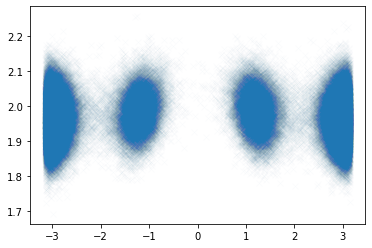

In [17]:
plt.scatter(dihe,ang1,marker='x',linewidth=0.01)

In [18]:

r2=np.corrcoef(dihe,ang1)[0,1]
print("R2:",r2)

line_fit=np.polyfit(dihe,ang1,1)
x = np.linspace(min(dihe), max(dihe),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 200000

In [ ]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2_bond,lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(dihe),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')

plt.xlabel('Time (ps)', size=15)
plt.xticks(size=15)
plt.ylabel('Auto Correlation', size=15)
plt.yticks(size=15)
plt.xlim(0,20)

plt.legend()

[0.000000e+00 1.000005e-01 2.000010e-01 ... 1.999980e+04 1.999990e+04
 2.000000e+04]


In [ ]:
dihedral_indices = [0,4,7,10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [dihedral_indices])

print(phi)

In [ ]:
import matplotlib.pyplot as plt
phicounts, torbinedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('C-C-C-C torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

In [ ]:
import numpy as np
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (torbinedges[1:] + torbinedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

In [ ]:
angle_indices = [0, 4, 7] 
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

In [ ]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
anglecounts[anglecounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(anglecounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C angle pmf')
plt.xlabel(r'bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

In [ ]:
bond_indices = [0, 1] 
bondlength = md.compute_distances(traj, [bond_indices])

bondcounts, bondbinedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond Length (nm)')
plt.ylabel('Counts')
plt.show()

In [ ]:
The C-H bond does not seem to obey a harmonic potential. 